# Test Functional Coherence of GO Terms in Clusters with True FlyBase Labels

In [1]:
from itertools import combinations
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from loguru import logger
from scipy.spatial.distance import jaccard
from scipy.stats import ttest_ind
from tqdm import tqdm

from philharmonic.utils import (
    load_cluster_json,
    parse_GO_database,
)

In [2]:
# Initial Files
cluster_file_path = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/d_melanogaster/20240913-dmelaAll-phil_v0.2.0/20240912-dmelaAll-phil_v0.2.0_clusters.functional.json"
network_file_path = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/d_melanogaster/20240913-dmelaAll-phil_v0.2.0/20240912-dmelaAll-phil_v0.2.0_network.positive.tsv"
go_map_path = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/d_melanogaster/20240913-dmelaAll-phil_v0.2.0/20240912-dmelaAll-phil_v0.2.0_GO_map.csv"
cluster_func_path = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/d_melanogaster/20240913-dmelaAll-phil_v0.2.0/20240912-dmelaAll-phil_v0.2.0_cluster_graph_functions.tsv"

GO_SLIM_PATH = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/goslim_generic.obo"
GO_FULL_PATH = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/go.obo"

IMG_DIR = Path("/mnt/home/ssledzieski/Projects/philharmonic-experiments/img/dmel")

---

## Load Files

In [3]:
# Load clusters
cluster_dict = load_cluster_json(cluster_file_path)

In [4]:
proteins_in_clusters = []
for clust in tqdm(cluster_dict.values()):
    proteins_in_clusters.extend(clust["members"])
    proteins_in_clusters.extend(list(clust["recipe"]["degree"]["0.75"]))

100%|██████████| 285/285 [00:00<00:00, 894742.99it/s]


In [5]:
# Add GO Annotations
USE_GO_SLIM = False

if USE_GO_SLIM:
    go_db = parse_GO_database(GO_SLIM_PATH)
else:
    go_db = parse_GO_database(GO_FULL_PATH)

In [6]:
flybase_go = pd.read_csv(
    "/mnt/home/ssledzieski/database/flybase/gene_association.fb",
    sep="\t",
    comment="!",
    header=None,
).dropna(subset=[10])
flybase_mapper = (
    pd.read_csv(
        "/mnt/home/ssledzieski/database/flybase/fbgn_fbtr_fbpp_fb_2024_04.tsv",
        sep="\t",
        comment="#",
        header=None,
    )
    .dropna()
    .drop_duplicates(2)
)
flybase_map = dict(zip(flybase_mapper[2], flybase_mapper[0], strict=False))

In [7]:
go_map_fb = {}
for k, v in tqdm(flybase_map.items(), total=len(flybase_map)):
    go_map_fb[f"7227.{k}"] = list(flybase_go[flybase_go[1] == v][4].unique())

100%|██████████| 30802/30802 [02:18<00:00, 221.82it/s]


In [8]:
go_map_fb = {k: v for k, v in go_map_fb.items() if k in proteins_in_clusters}
logger.info(f"{len(go_map_fb)} proteins mapped with GO terms")

2025-01-02 13:40:17.954 | INFO     | __main__:<module>:2 - 4000 proteins mapped with GO terms


---

## Native Cluster Coherence

In [168]:
go_assigned = set()
for clust in tqdm(cluster_dict.values()):
    for m in clust["members"]:
        go_assigned.update(go_map_fb.get(m, []))
go_assigned = sorted(list(go_assigned.intersection(go_db.keys())))

logger.info(f"{len(go_assigned)} GO terms assigned")

100%|██████████| 285/285 [00:00<00:00, 28462.03it/s]
2025-01-02 14:26:04.885 | INFO     | __main__:<module>:7 - 5461 GO terms assigned


In [169]:
def protein_GO_bit_vector(protein_id, go_map, full_go_list):
    go_bv = np.zeros(len(full_go_list))
    prot_go = go_map.get(protein_id)
    if prot_go is not None:
        for gid in prot_go:
            if gid in full_go_list:
                go_bv[full_go_list.index(gid)] = 1
    return go_bv


protein_GO_bvs = {}
for pid in tqdm(proteins_in_clusters):
    protein_GO_bvs[pid] = protein_GO_bit_vector(pid, go_map_fb, go_assigned)

100%|██████████| 6949/6949 [00:02<00:00, 3411.12it/s]


In [170]:
cluster_jaccards = {}

for k, clust in tqdm(cluster_dict.items()):
    cjaccard = []
    for p1, p2 in combinations(
        clust["members"] + list(clust["recipe"]["degree"]["0.75"]), 2
    ):
        jc = 1 - jaccard(protein_GO_bvs[p1], protein_GO_bvs[p2])
        cjaccard.append(jc)
    cluster_jaccards[k] = np.array(cjaccard)

100%|██████████| 285/285 [00:42<00:00,  6.65it/s]


---

## Shuffled Cluster Coherence

In [171]:
rng = np.random.default_rng(seed=42)
shuffled_bit_vectors = {
    k: v
    for k, v in zip(
        protein_GO_bvs.keys(),
        rng.permutation(list(protein_GO_bvs.values())),
        strict=False,
    )
}

In [172]:
cluster_jaccards_perm = {}

for k, clust in tqdm(cluster_dict.items()):
    cjaccard = []
    for p1, p2 in combinations(
        clust["members"] + list(clust["recipe"]["degree"]["0.75"]), 2
    ):
        jc = 1 - jaccard(shuffled_bit_vectors[p1], shuffled_bit_vectors[p2])
        cjaccard.append(jc)
    cluster_jaccards_perm[k] = np.array(cjaccard)

100%|██████████| 285/285 [00:45<00:00,  6.32it/s]


--- 


## Compare shuffled and original coherence

In [173]:
phil_mean = [np.mean(i) for i in cluster_jaccards.values()]
permute_mean = [np.mean(i) for i in cluster_jaccards_perm.values()]
coherence_df = (
    pd.DataFrame(
        {
            "cluster": list(cluster_jaccards.keys()),
            "PHILHARMONIC": phil_mean,
            "Random Clustering": permute_mean,
        }
    )
    .melt("cluster")
    .rename(
        {"variable": "Clustering Method", "value": "Mean Jaccard Similarity"}, axis=1
    )
)
coherence_df.head()

,cluster,Clustering Method,Mean Jaccard Similarity
0,747394121115208532,PHILHARMONIC,0.104113
1,1614852247292496341,PHILHARMONIC,0.099445
2,402506198413014357,PHILHARMONIC,0.357565
3,910498388155438464,PHILHARMONIC,0.083957
4,1015360824453328460,PHILHARMONIC,0.124797


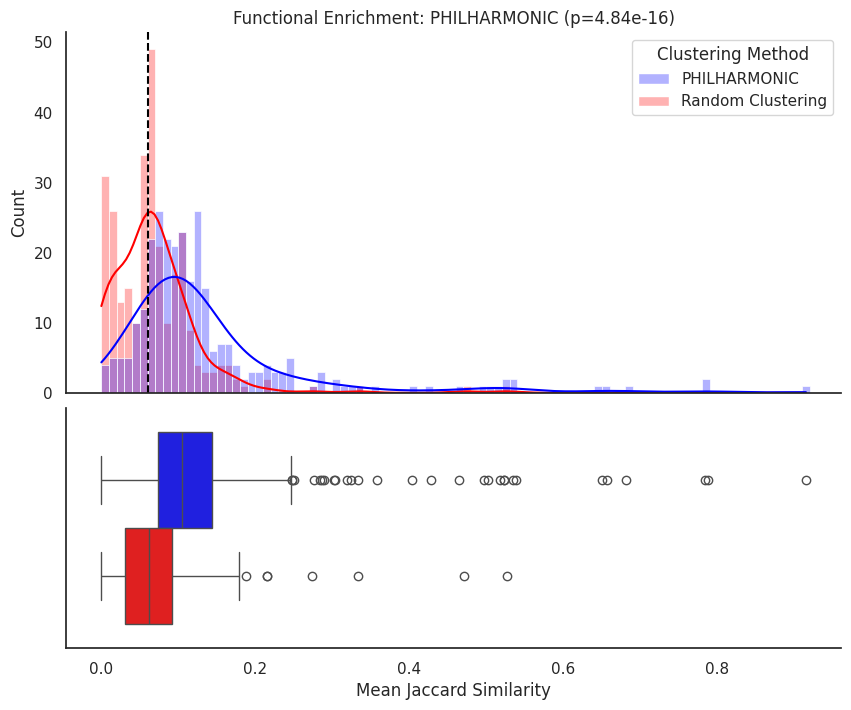

In [174]:
sns.set_palette("colorblind")
sns.set_theme(style="white", palette="pastel", font_scale=1)

# Create figure and gridspec
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(2, 1, height_ratios=[3, 2], hspace=0.05)

# Create top subplot for histogram
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])

sns.histplot(
    data=coherence_df,
    x="Mean Jaccard Similarity",
    hue="Clustering Method",
    alpha=0.3,
    bins=np.arange(0, 1.05, 0.01),
    kde=True,
    palette=["blue", "red"],
    common_norm=False,
    ec="white",
    ax=ax0,
)

sns.boxplot(
    data=coherence_df,
    x="Mean Jaccard Similarity",
    hue="Clustering Method",
    palette=["blue", "red"],
    ax=ax1,
)

ax0.set_xlabel("")  # Remove x-label from top plot
ax0.set_xticklabels([])  # Remove x-ticks from top plot

# Align the x-axis of both subplots
ax0.set_xlim(ax1.get_xlim())
ax1.get_legend().remove()  # Remove legend from bottom plot

tstat, p = ttest_ind(phil_mean, permute_mean, alternative="greater")
ax0.set_title(f"Functional Enrichment: PHILHARMONIC (p={p:.3})")

if USE_GO_SLIM:
    ax0.axvline(0.25, linestyle="--", color="black")
else:
    ax0.axvline(0.06, linestyle="--", color="black")

# Show the plot
sns.despine()
finame = (
    "enrichment_by_function_swarmbox_GOfull.svg"
    if not USE_GO_SLIM
    else "enrichment_by_function_swarmbox_GOslim.svg"
)
# plt.savefig(IMG_DIR / finame, bbox_inches="tight", dpi=300)
plt.show()

---
## Display Coherence by GO Slim Function

In [175]:
cluster_top_terms = pd.read_csv(cluster_func_path, sep="\t").set_index("key")

clens = [len(clust["members"]) for clust in cluster_dict.values()]
clen_bin = pd.cut(clens, bins=[0, 5, 10, 15, 20, 25, 30])
cjacc = [np.mean(cluster_jaccards[k]) for k in cluster_dict]
cfunc = [cluster_top_terms.loc[int(k), "go_fn"] for k in cluster_dict]

func_df = pd.DataFrame(
    {
        "Function": cfunc,
        "Mean Jaccard Similarity": cjacc,
        "Cluster Size": clens,
    }
)
func_df["Function"] = func_df["Function"].str.lower()
func_df = func_df.sort_values("Function")
func_df["Function"].fillna("No dominant function", inplace=True)

logger.info(func_df.shape)

/tmp/ipykernel_1856063/1212112920.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  func_df["Function"].fillna("No dominant function", inplace=True)
2025-01-02 14:27:35.482 | INFO     | __main__:<module>:19 - (285, 3)


In [176]:
import xml.etree.ElementTree as ET

# Define the path to the XML file
xml_file_path = "../assets/philharmonic_styles.xml"

# Parse the XML file
tree = ET.parse(xml_file_path)
root = tree.getroot()

# Extract colors from the "philharmonic" style
philharmonic_colors = {}
for style in root.findall(".//discreteMappingEntry"):
    name = style.get("attributeValue").lower()
    value = style.get("value")
    philharmonic_colors[name] = value

for f in func_df["Function"].unique():
    if f not in philharmonic_colors.keys():
        philharmonic_colors[f] = "#aaaaaa"

In [177]:
grouped_order = (
    func_df.loc[:, ["Function", "Mean Jaccard Similarity"]]
    .groupby(["Function"])
    .median()
    .sort_values(by="Mean Jaccard Similarity")
)

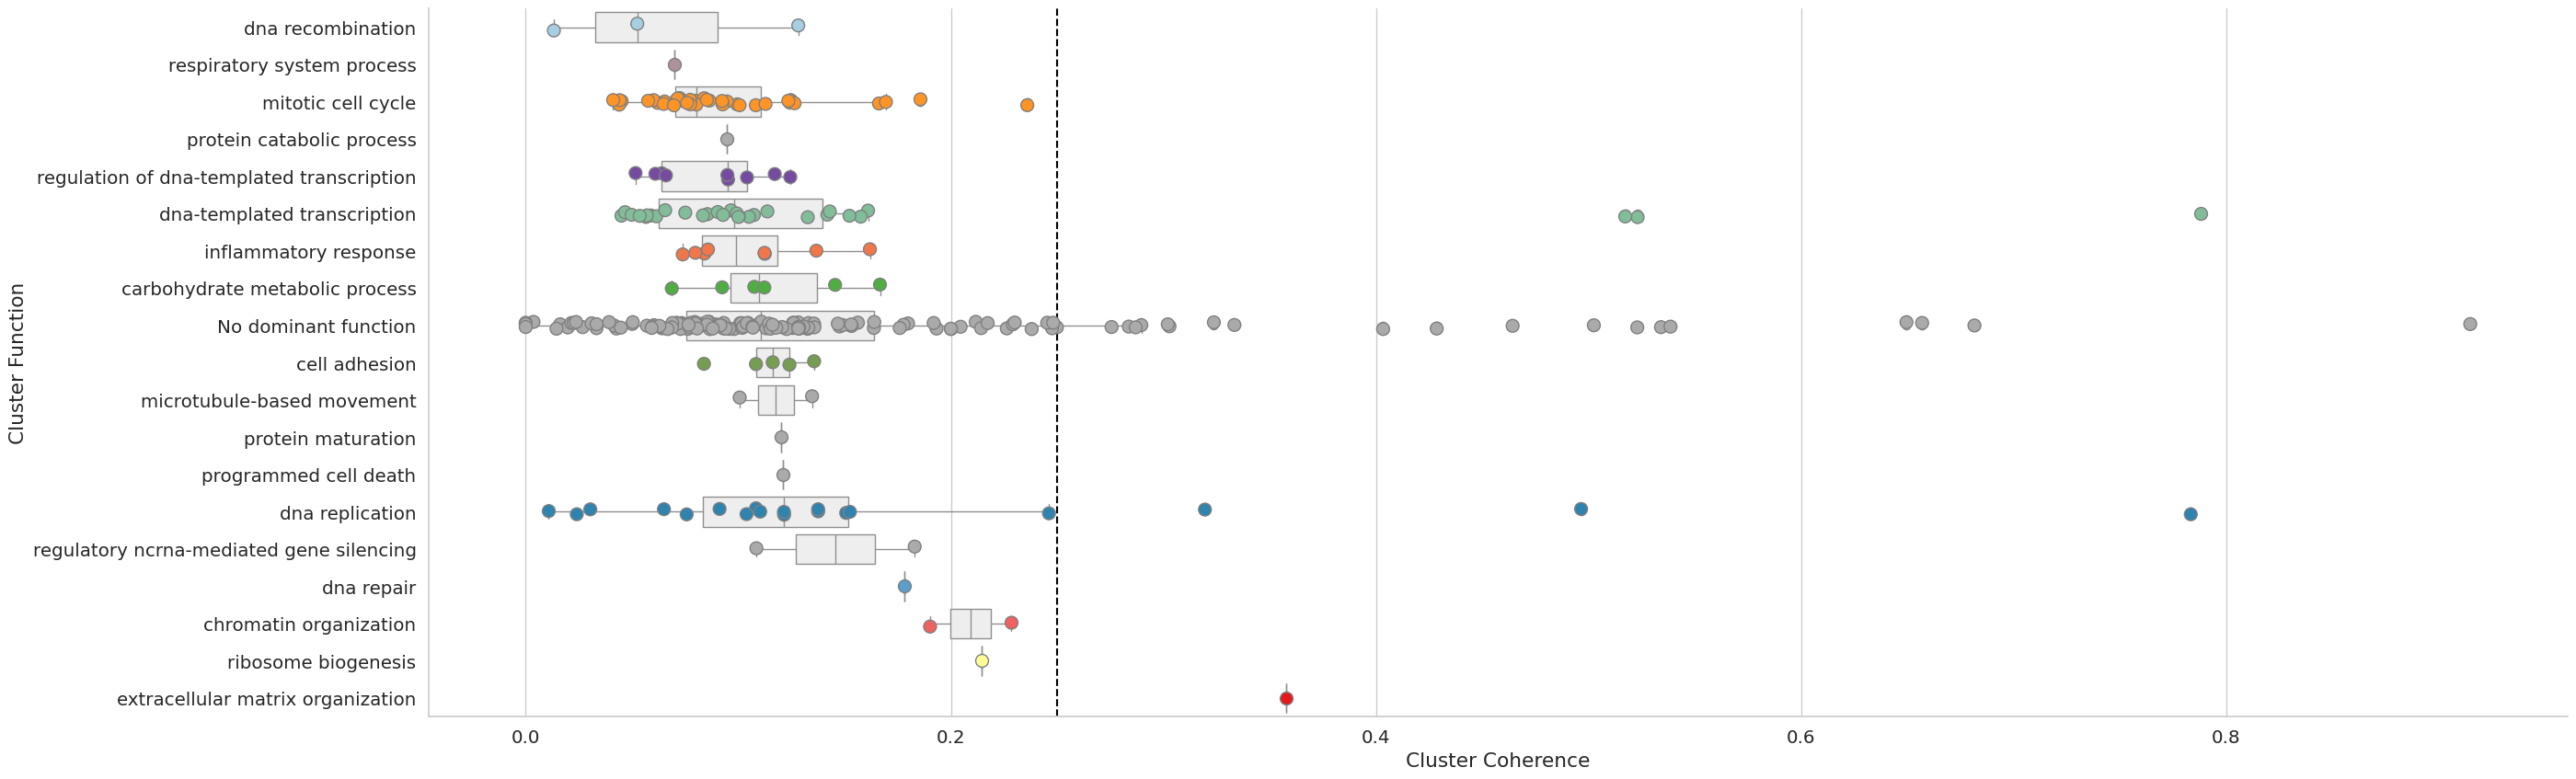

In [178]:
sns.set_theme(style="whitegrid", font_scale=1.3)
fig, ax = plt.subplots(figsize=(30, 10))

sns.stripplot(
    data=func_df,
    x="Mean Jaccard Similarity",
    y="Function",
    ax=ax,
    hue="Function",
    palette=philharmonic_colors,
    order=grouped_order.index,
    s=10,
    edgecolor="grey",
    linewidth=1,
)
sns.boxplot(
    data=func_df,
    x="Mean Jaccard Similarity",
    y="Function",
    ax=ax,
    hue="Function",
    palette={k: "#eeeeee" for k in func_df["Function"].unique()},
    order=grouped_order.index,
)
plt.xlabel("Cluster Coherence")
plt.ylabel("Cluster Function")
plt.axvline(0.25, linestyle="--", color="black")


sns.despine()
# plt.savefig(
# IMG_DIR / "enrichment_by_function_swarmbox_slimGO.svg", bbox_inches="tight", dpi=300
# )
plt.show()

---

## Compare Cluster Pathway Membership

In [8]:
flybase_group = pd.read_csv(
    "/mnt/home/ssledzieski/database/flybase/gene_group_data_fb_2024_06.tsv",
    sep="\t",
    comment="#",
    header=None,
)
flybase_group.columns = [
    "fbid",
    "fbgrp_symbol",
    "fbgrp_name",
    "parent_fbgrp_id",
    "parent_fbgrp_symbol",
    "group_member_geneid",
    "group_member_symbol",
]
flybase_inv_map = {v: k for k, v in flybase_map.items()}
flybase_group["fbpp"] = flybase_group["group_member_geneid"].map(flybase_inv_map)
flybase_group = flybase_group.dropna(subset=["fbpp"])
pic_strip = [flybase_map.get(i.split(".")[1], None) for i in proteins_in_clusters]
flybase_group = flybase_group[flybase_group["group_member_geneid"].isin(pic_strip)]

In [9]:
group_map = {}
for k, v in tqdm(flybase_map.items(), total=len(flybase_map)):
    group_map[f"7227.{k}"] = list(
        flybase_group[flybase_group["group_member_geneid"] == v][
            "fbgrp_symbol"
        ].unique()
    )

group_map = {k: v for k, v in group_map.items() if k in proteins_in_clusters}
logger.info(f"{len(group_map)} proteins mapped with groups terms")

100%|██████████| 30802/30802 [00:08<00:00, 3611.13it/s]
2025-01-06 11:24:55.280 | INFO     | __main__:<module>:6 - 4000 proteins mapped with groups terms


In [10]:
group_assigned = set()
for clust in tqdm(cluster_dict.values()):
    for m in clust["members"] + list(clust["recipe"]["degree"]["0.75"]):
        group_assigned.update(group_map.get(m, []))
group_assigned = sorted(list(group_assigned))

logger.info(f"{len(group_assigned)} groups assigned")

100%|██████████| 285/285 [00:00<00:00, 114973.23it/s]
2025-01-06 11:24:55.291 | INFO     | __main__:<module>:7 - 853 groups assigned


In [11]:
def protein_group_bit_vector(protein_id, group_map, full_group_list):
    group_bv = np.zeros(len(full_group_list))
    prot_group = group_map.get(protein_id)
    if prot_group is not None:
        for gid in prot_group:
            if gid in full_group_list:
                group_bv[full_group_list.index(gid)] = 1
    return group_bv


protein_group_bvs = {}
for pid in tqdm(proteins_in_clusters):
    protein_group_bvs[pid] = protein_group_bit_vector(pid, group_map, group_assigned)

100%|██████████| 6949/6949 [00:00<00:00, 140792.79it/s]


In [12]:
cluster_jaccards = {}

for k, clust in tqdm(cluster_dict.items()):
    cjaccard = []
    for p1, p2 in combinations(
        clust["members"] + list(clust["recipe"]["degree"]["0.75"]), 2
    ):
        jc = 1 - jaccard(protein_group_bvs[p1], protein_group_bvs[p2])
        cjaccard.append(jc)
    cluster_jaccards[k] = np.array(cjaccard)

100%|██████████| 285/285 [00:00<00:00, 435.45it/s]


In [13]:
rng = np.random.default_rng(seed=42)
shuffled_group_bit_vectors = {
    k: v
    for k, v in zip(
        protein_group_bvs.keys(),
        rng.permutation(list(protein_group_bvs.values())),
        strict=False,
    )
}

In [14]:
cluster_jaccards_perm = {}

for k, clust in tqdm(cluster_dict.items()):
    cjaccard = []
    for p1, p2 in combinations(
        clust["members"] + list(clust["recipe"]["degree"]["0.75"]), 2
    ):
        jc = 1 - jaccard(shuffled_group_bit_vectors[p1], shuffled_group_bit_vectors[p2])
        cjaccard.append(jc)
    cluster_jaccards_perm[k] = np.array(cjaccard)

100%|██████████| 285/285 [00:00<00:00, 429.26it/s]


In [15]:
phil_mean = [np.mean(i) for i in cluster_jaccards.values()]
permute_mean = [np.mean(i) for i in cluster_jaccards_perm.values()]
coherence_df = (
    pd.DataFrame(
        {
            "cluster": list(cluster_jaccards.keys()),
            "PHILHARMONIC": phil_mean,
            "Random Clustering": permute_mean,
        }
    )
    .melt("cluster")
    .rename(
        {"variable": "Clustering Method", "value": "Mean Jaccard Similarity"}, axis=1
    )
)
coherence_df.head()

,cluster,Clustering Method,Mean Jaccard Similarity
0,747394121115208532,PHILHARMONIC,0.114016
1,1614852247292496341,PHILHARMONIC,0.124150
2,402506198413014357,PHILHARMONIC,0.277915
3,910498388155438464,PHILHARMONIC,0.093537
4,1015360824453328460,PHILHARMONIC,0.087536


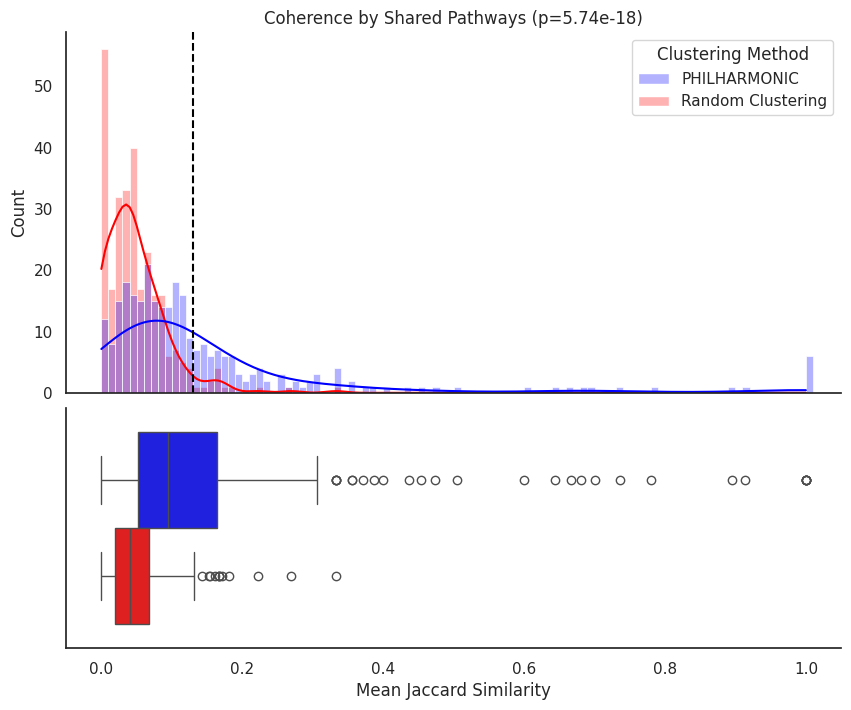

In [17]:
sns.set_palette("colorblind")
sns.set_theme(style="white", palette="pastel", font_scale=1)

# Create figure and gridspec
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(2, 1, height_ratios=[3, 2], hspace=0.05)

# Create top subplot for histogram
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])

sns.histplot(
    data=coherence_df,
    x="Mean Jaccard Similarity",
    hue="Clustering Method",
    alpha=0.3,
    bins=np.arange(0, 1.05, 0.01),
    kde=True,
    palette=["blue", "red"],
    common_norm=False,
    ec="white",
    ax=ax0,
)

sns.boxplot(
    data=coherence_df,
    x="Mean Jaccard Similarity",
    hue="Clustering Method",
    palette=["blue", "red"],
    ax=ax1,
)

ax0.set_xlabel("")  # Remove x-label from top plot
ax0.set_xticklabels([])  # Remove x-ticks from top plot

# Align the x-axis of both subplots
ax0.set_xlim(ax1.get_xlim())
ax1.get_legend().remove()  # Remove legend from bottom plot

tstat, p = ttest_ind(phil_mean, permute_mean, alternative="greater")
ax0.set_title(f"Coherence by Shared Pathways (p={p:.3})")

if USE_GO_SLIM:
    ax0.axvline(0.25, linestyle="--", color="black")
else:
    ax0.axvline(0.13, linestyle="--", color="black")

# Show the plot
sns.despine()
finame = (
    "enrichment_by_shared_pathway_swarmbox_GOfull.png"
    if not USE_GO_SLIM
    else "enrichment_by_shared_pathway_swarmbox_GOslim.png"
)
plt.savefig(IMG_DIR / finame, bbox_inches="tight", dpi=300)
plt.show()

In [125]:
with_recipe = True
reports = []
for i in range(len(cluster_dict)):
    clust = cluster_dict[list(cluster_dict.keys())[i]]["members"]
    if with_recipe:
        clust.extend(
            cluster_dict[list(cluster_dict.keys())[i]]["recipe"]["degree"]["0.75"]
        )
    clust_strip = [i.split(".")[1] for i in clust]
    clust_group = flybase_group[flybase_group["fbpp"].isin(clust_strip)]
    n_genes = clust_group["fbpp"].nunique()
    n_paths = clust_group["fbgrp_symbol"].nunique()
    reports.append((n_genes, n_paths, n_paths / (n_genes + np.finfo(float).eps)))

In [239]:
coherence_df.sort_values("Mean Jaccard Similarity", ascending=False).head(30)

,cluster,Clustering Method,Mean Jaccard Similarity
278,1491610535263795008,PHILHARMONIC,1.000000
268,1018487175490541677,PHILHARMONIC,1.000000
276,726300285769309616,PHILHARMONIC,1.000000
277,2037677424131251085,PHILHARMONIC,1.000000
263,1509071162690152256,PHILHARMONIC,1.000000
32,715185345242919955,PHILHARMONIC,1.000000
47,1891968001179543488,PHILHARMONIC,0.913043
78,83537245932675549,PHILHARMONIC,0.894737
22,1803626238920177605,PHILHARMONIC,0.780000
200,1780801533437984591,PHILHARMONIC,0.752203


In [250]:
cluster_jaccards

{'747394121115208532': array([0.        , 0.        , 0.33333333, ..., 0.        , 0.        ,
        0.        ], shape=(47586,)),
 '1614852247292496341': array([0., 0., 0., ..., 0., 0., 0.], shape=(36046,)),
 '402506198413014357': array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.5       ,

In [253]:
# i = 142
# clust = cluster_dict[list(cluster_dict.keys())[i]]["members"]
clust = cluster_dict["1454309218749130379"]["members"]
if with_recipe:
    clust.extend(cluster_dict["1454309218749130379"]["recipe"]["degree"]["0.75"])
clust_strip = [i.split(".")[1] for i in clust]
clust_group = flybase_group[flybase_group["fbpp"].isin(clust_strip)]
n_genes = clust_group["fbpp"].nunique()
n_paths = clust_group["fbgrp_symbol"].nunique()
print(n_genes, n_paths, n_paths / (n_genes + np.finfo(float).eps))
clust_group

4 8 2.0


,fbid,fbgrp_symbol,fbgrp_name,parent_fbgrp_id,parent_fbgrp_symbol,group_member_geneid,group_member_symbol,fbpp
2077,FBgg0001590,DEAD,DEAD-BOX RNA HELICASES,FBgg0001589,RNAHEL,FBgn0032919,pths,FBpp0080997
2080,FBgg0001590,DEAD,DEAD-BOX RNA HELICASES,FBgg0001589,RNAHEL,FBgn0037573,CG7483,FBpp0081324
3231,FBgg0001586,RUVB,RUVB-LIKE DNA HELICASES,FBgg0001582,DNAHEL,FBgn0040078,pont,FBpp0081704
3771,FBgg0001790,SWR1,SWR1 COMPLEX,NaN,NaN,FBgn0040078,pont,FBpp0081704
5318,FBgg0000291,INO80,INO80 COMPLEX,FBgg0000284,REMOD-C,FBgn0040078,pont,FBpp0081704
6248,FBgg0001632,CACTT,C-ACETYLTRANSFERASES,FBgg0001169,ACTT,FBgn0036208,Gcat,FBpp0075815
8594,FBgg0000287,TIP60,TIP60 COMPLEX,FBgg0000284,REMOD-C,FBgn0040078,pont,FBpp0081704
8610,FBgg0000287,TIP60,TIP60 COMPLEX,FBgg0000300,CHR-MOD-C,FBgn0040078,pont,FBpp0081704
10245,FBgg0000536,SPL-C-C,SPLICEOSOME COMPLEX C,FBgg0000537,SPL-INT,FBgn0037573,CG7483,FBpp0081324
11406,FBgg0000569,SLP-C-P,SPLICEOSOME COMPLEX P,FBgg0000537,SPL-INT,FBgn0037573,CG7483,FBpp0081324


In [126]:
reports = pd.DataFrame(reports)
reports

,0,1,2
0,23,19,0.826087
1,25,23,0.920000
2,20,5,0.250000
3,18,19,1.055556
4,20,20,1.000000
...,...,...,...
280,2,3,1.500000
281,0,0,0.000000
282,4,3,0.750000
283,2,1,0.500000
